This notebook includes many simulation to study many statisitcal problems

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [4]:
rng = np.random.RandomState(8888)

In [5]:
n = 100
true_y = rng.normal(size=n,loc = 0,scale=3)
np.var(true_y)

8.862893068247667

Samples are correlated (some user's measurement were taken multiple times), bootstrap can correct it (assuming `true_y` is I.I.D)

__Recall from A/B Testing books: Having the randomization unit be coarser than the analysis uniut, such as randomizing by user and the click-through rate (by page) , will work, but requires more nuanced anlayses methods such as bootstrap or the delta method__.

In [6]:
n_replicates = 1000
out = rng.choice(true_y,size=(n_replicates,n))

In [7]:
np.mean(out.var(axis=1))

8.834754276635184

__Outlier effect on A/B testing, p-value of 0.32 and T-stat of 1.__

https://statisticaloddsandends.wordpress.com/2020/10/01/p-value-around-0-32-you-may-have-a-problem-with-outliers/

In [15]:
n = 100
a = rng.uniform(size = n)
b = rng.uniform(size = n)
stats.ttest_1samp(a,popmean= 1/2 )

Ttest_1sampResult(statistic=-1.4600255827489745, pvalue=0.14744918186569625)

#### still same conclusion (insignificant) due to cancellation of the outlier in both numerator and denominator

Assume paired test

In [16]:
a[-1] = 10000
stats.ttest_1samp(a,popmean=1/2)

Ttest_1sampResult(statistic=0.9996142250135274, pvalue=0.31993426353989773)

In [17]:
stats.ttest_1samp(a-b,popmean=0)

Ttest_1sampResult(statistic=0.999533781835471, pvalue=0.31997301403859324)

In [18]:
stats.ttest_rel(a,b)

Ttest_relResult(statistic=0.999533781835471, pvalue=0.31997301403859324)

Assume independent two sample test

In [19]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.31873277752641305)

In [20]:
stats.ttest_ind(a,b,permutations = 1000)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.87)

__T-stats__

In [13]:
a.mean()/(a.std()/np.sqrt(n))

1.0102845891186012

## Permutation test

Non-parametric test when the normality of tests do not hold

In [65]:
n = 100
treat_effect = 0.3
control = 1 + np.random.normal(size = n)
treatment = 1 + np.random.normal(size = n) + treat_effect

In [66]:
stats.ttest_ind(control,treatment)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.005324791945203552)

In [67]:
stats.ttest_ind(control,treatment,permutations = 10000)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.0041)

## Bootstrap with parallel

### non-parametric bootstrap

In [3]:
from joblib import Parallel, delayed # for parallel processing
import numpy as np
x = np.random.normal(size = 100, scale =10)
bootstrap_samples = 100
def std_sample(x):
    x = np.random.choice(x,size = len(x),replace = True)
    return(x.std())
out = Parallel(n_jobs = 10)(delayed(std_sample)(x) for _ in range(bootstrap_samples))

np.quantile(out,[0.025,0.5,0.975])

array([ 7.83456167,  8.84695193, 10.07557688])

In [6]:
from joblib import delayed, Parallel
import scipy.stats as ss
import numpy as np

In [61]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
def var_sample(x):
    x_boot = np.random.choice(x, size = len(x), replace = True)
    return np.median(x_boot)

In [62]:
boot_median = Parallel(n_jobs = 10)(delayed(var_sample)(x) for _ in range(n_boot_samples))
np.var(boot_median)

0.024537052995451843

### Parametric bootstrap

Use sample statistic and assumes a parametric distribution.

In [63]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
sample_median = np.median(x)
def var_sample(x0):
    x_par = ss.cauchy.rvs(size = 100,loc = x0)
    return np.median(x_par)

In [64]:
para_bootstrap = Parallel(n_jobs = 10)(delayed(var_sample)(sample_median) for _ in range(n_boot_samples))
np.var(para_bootstrap)

0.02447355007653579

### Bootstrap T-method

In [20]:
rng = np.random.RandomState(0)
n = 500
p = 1
x = rng.normal(size=(n,p))
beta = [1,5]
y = np.dot(np.concatenate((np.repeat(1,n)[:,None],x),axis=1),beta) + rng.normal(size =n)

In [21]:
import pandas as pd
data = pd.DataFrame(np.concatenate((y[:,None],x),axis=1),columns = ["y",'x'])
              

#### percentile CI method

In [22]:
## percentile CI method
import statsmodels.formula.api as smf
n_boot = 1000
def get_ratio_boot(data):
    coef = smf.ols("y~x",data = data).fit().params
    return coef[1]/coef[0]

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True)) for _ in range(n_boot))

In [23]:
np.quantile(out,[0.025,0.975])

array([4.85929696, 5.82460528])

#### T method

In [24]:
## percentile CI method
import statsmodels.formula.api as smf
n_boot = 1000
model = smf.ols("y~x",data = data).fit()
model_coef = model.params
coef_cov = model.cov_params()
theta_hat = model_coef[1] / model_coef[0]
sigma2_delta = theta_hat**2 * (coef_cov.iloc[1,1]/(model_coef[1]**2)  + coef_cov.iloc[0,0]/(model_coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (model_coef[0] * model_coef[1]))

def get_ratio_boot(data,theta_hat):
    model = smf.ols("y~x",data = data).fit()
    coef = model.params
    coef_cov = model.cov_params()
    theta_hat_boot =  coef[1]/coef[0]
    sigma2_delta = theta_hat_boot**2 * (coef_cov.iloc[1,1]/(coef[1]**2)  + coef_cov.iloc[0,0]/(coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (coef[0] * coef[1]))
    return ((theta_hat_boot-theta_hat) / np.sqrt(sigma2_delta))

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True), theta_hat) for _ in range(n_boot))

In [26]:
t_quant = np.quantile(out,[0.025,0.975])
theta_hat + t_quant * np.sqrt(sigma2_delta)

array([4.76660753, 5.76852671])

## Given U(0,1), sample discrete distribution (a,b)

<AxesSubplot:ylabel='Count'>

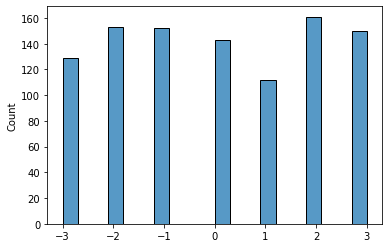

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def map_u_to_discrete(a,b,n=1000):
    x = np.random.uniform(size = n)
    y = np.linspace(a,b,b-a+1)
    buckets = np.linspace(0,1,b-a+2)[1:]
    return [y[np.where(x_i<=buckets)[0][0]] for x_i in x]
out = map_u_to_discrete(-3,3)
sns.histplot(out,bins=20)

## Given U(0,1) generate binomial(n = 4, p =5/8)

<AxesSubplot:ylabel='Count'>

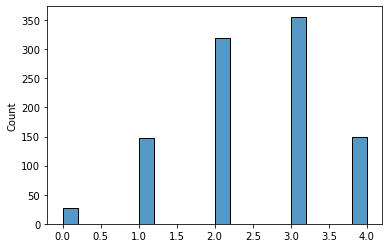

In [125]:
from scipy.stats import binom

p = binom.cdf(k= np.linspace(0,4,5),n=4,p=5/8)
x = np.random.uniform(size = 1000)
y_samples = [np.where(x_i <= p)[0][0] for x_i in x]
sns.histplot(y_samples,bins=20)

In [124]:
p

array([0.01977539, 0.15161133, 0.48120117, 0.84741211, 1.        ])

## OLS R style formula trick 

In [4]:
import statsmodels.formula.api as smf
feature_name = ['x1','x2','x3']
formula = "y~"+"+".join(feature_name)
print(formula)
#model = smf.ols(formula,data = data).fit()

y~x1+x2+x3
